# Calculate distance from cities in UCDB dataset

1. Distance to shoreline (shoreline is the OCEAN MASK dataset from the official World Bank boundaries)
2. Distance to border (from WB GAD)

In [29]:
import sys
import os
import itertools
import rasterio

import geopandas as gpd
import pandas as pd
import numpy as np

from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
from operator import itemgetter

sys.path.insert(0, "C:/WBG/Work/Code/GOSTrocks/src")

import GOSTrocks.ntlMisc as ntlMisc
import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.shapeMisc as shapeMisc
import GOSTrocks.misc as misc
from GOSTrocks.misc import tPrint

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
data_folder = r"C:\WBG\Work\data\URBAN"

ucdb_file = os.path.join(data_folder, "GHS_UCDB_GLOBE_R2024A.gpkg")
# fua_file = os.path.join(data_folder, "GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")
# fua_peripheries = os.path.join(data_folder, "FUA_peripheries.gpkg")
# oxford_extents = os.path.join(data_folder, "OE_FUA_SHAPEFILE", "OE_FUA_SHAPEFILE.shp")

ucdb_id = "ID_UC_G0"

coastline_file = r"C:\WBG\Work\data\ADMIN\BETTER_FORMATS\ocean_mask.gpkg"
border_file = r"C:\WBG\Work\data\ADMIN\BETTER_FORMATS\WB_GAD_Lines.gpkg"

out_folder = r"C:\WBG\Work\Projects\MENA_Urban\RESULTS\DISTANCE"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

In [ ]:
inU = gpd.read_file(ucdb_file)
inU = inU.loc[:, [ucdb_id, "geometry"]]
inU.head()

In [ ]:
inCoasts = gpd.read_file(coastline_file)
inCoasts.explore()

In [8]:
inCoasts.head()

,id,geometry
0,1,None


In [33]:
inCoasts = gpd.read_file(coastline_file)
inCoasts['geometry'] = inCoasts.geometry.buffer(0)
inCoasts = misc.explodeGDF(inCoasts)
inCoasts['geometry'] = inCoasts.geometry.exterior

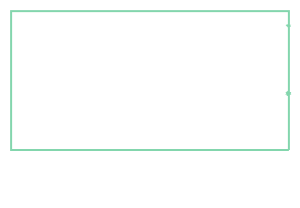

In [31]:
inCoasts['geometry'] = inCoasts['geometry'].apply(lambda x: LineString(x.coords))

In [32]:
inCoasts.to_file(os.path.join(out_folder, "coastlines.gpkg"), driver="GPKG")
inCoasts.to_crs(inU.crs).to_file(os.path.join(out_folder, "coastlines_proj.gpkg"), driver="GPKG")

c:\wbg\Anaconda3\envs\s2s_ingest\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field format '' not supported
  ogr_write(
c:\wbg\Anaconda3\envs\s2s_ingest\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Layer coastlines relies on the 'gpkg_geom_' (http://www.geopackage.org/spec120/#extension_geometry_types) extension that should be implemented in order to read/write it safely, but is not currently. Some data may be missing while reading that layer, and updates are strongly discouraged.
  ogr_write(
c:\wbg\Anaconda3\envs\s2s_ingest\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field format '' not supported
  ogr_write(
c:\wbg\Anaconda3\envs\s2s_ingest\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Layer coastlines_proj relies on the 'gpkg_geom_' (http://www.geopackage.org/spec120/#extension_geometry_types) extension that should be implemented in order to read/write it safely, but is not currently. Some data may be missing while reading that layer, and update

In [ ]:
inCoasts = gpd.read_file(coastline_file)
inCoasts.explode(index_parts=True, ignore_index=True, inplace=True)
inCoasts['ID'] = list(range(0, len(inCoasts)))
inCoasts = inCoasts.to_crs(inU.crs)
inCoasts = misc.explodeGDF(inCoasts)
inCoasts.drop(['level_0', 'index', 'id'], inplace=True, axis=1, errors='ignore')

inBorders = gpd.read_file(border_file)
inBorders.explode(index_parts=True, ignore_index=True, inplace=True)
inBorders['ID'] = list(range(0, len(inBorders)))
inBorders = inBorders.to_crs(inU.crs)
inBorders = misc.explodeGDF(inBorders)
inBorders.drop(['level_0', 'index'], inplace=True, axis=1, errors='ignore')

In [ ]:
tPrint("Started")
inU_borders = gpd.sjoin_nearest(inU, inBorders, how="left", distance_col="BORDER_DIST")
tPrint("Finished border distances")
inU_coasts = gpd.sjoin_nearest(inU, inCoasts, how="left", distance_col="COAST_DIST")
tPrint("Finished coastline distances")


In [ ]:
inU_borders.head()

In [ ]:
inU_coasts.head()

In [ ]:
inU_combined = pd.merge(inU_borders, inU_coasts[[ucdb_id, "COAST_DIST"]], on=ucdb_id)
inU_combined.to_file(os.path.join(out_folder, "UCDB_distances.gpkg"), driver="GPKG", index=False)